In [1]:
import sys
sys.path.append('..')
from utils import * 
from statsmodels.stats.weightstats import DescrStatsW
import seaborn as sns
from fof_savings import *

In [ ]:
fof = get_fof()
subcategory_shares = get_subcategory_shares(fof)
subcategory_shares = subcategory_shares[subcategory_shares.Year.isin([1983,1989])]

In [2]:
pd.options.display.float_format = '{:,.3f}'.format

In [3]:
def weighted_quantile(values, weights, quantiles):
    sorter = np.argsort(values)
    values = values[sorter]
    weights = weights[sorter]
    weighted_quantiles = np.cumsum(weights) - 0.5 * weights
    weighted_quantiles /= np.sum(weights)
    
    weighted_quantiles = np.interp(quantiles, weighted_quantiles, values)
    weighted_quantiles[-1] = values.max()
    return weighted_quantiles

def assign_percentile_group(row, quantile_values, quantile_labels, col):
    return quantile_labels[np.searchsorted(quantile_values, row[col], side='left')]

In [437]:
def annualize_transitions(matrix, years=5):
    # This is over 6 years--convert to annual basis
    # Step 1: Diagonalize Gamma
    eigenvalues, V = np.linalg.eig(matrix)
    D = np.diag(eigenvalues)

    # Step 2: Compute sixth roots of the eigenvalues
    D_root = np.diag(np.power(eigenvalues, 1/years))

    # Step 3: Recompose Q using V, D_root, and V^-1
    V_inv = np.linalg.inv(V)
    Lambda = V @ D_root @ V_inv
    
    # Step 4: Deal with negatives -- set to 0 and re-normalize
    Lambda[Lambda < 0] = 0
    Lambda/Lambda.sum(axis=1, keepdims=True)
    
    return Lambda

In [374]:
def get_transition_matrix(df, quantiles, quantile_labels, col1='networth1983', col2='networth1989', weight_var='weight'):
    for col in [col1, col2]:
        df = get_percentile_group(df, col=col, weight=weight_var, tag=f'_{col}', quantiles=quantiles, quantile_labels=quantile_labels)
    
    # Get transition probabilities
    transition_matrix = pd.DataFrame(
        0, index=quantile_labels, columns=quantile_labels, dtype=float
    )

    # Count transitions
    for _, row in df.iterrows():
        from_percentile = row[f'percentile_{col1}']
        to_percentile = row[f'percentile_{col2}']
        transition_matrix.loc[from_percentile, to_percentile] += row[weight_var]

    # Normalize to probabilities
    transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0).fillna(0)
    return transition_matrix

In [375]:
def get_percentile_group(df, col='networth1983', weight='weight', tag='', quantiles=np.linspace(1, 100, 100)/100, quantile_labels=np.arange(0,100)):
    quantile_values = weighted_quantile(df[col], df[weight], quantiles)
    df[f'percentile{tag}'] = df.apply(assign_percentile_group, axis=1, quantile_values=quantile_values, quantile_labels=quantile_labels, col=col)
    return df

In [367]:
def load_scf(scf_dict, filename='rscfp2009panel.dta', year1=2007, year2=2009, id_vars=['id2009','case_id'], id_dict={'YY1':'id2009', 'Y1':'case_id'}, weight_var='WGT09'):
    scf = load_data(filename, folder=os.path.join('raw','scf',f'scf_{year1}-{year2}_panel'))
    
    if year1==1983 and year2==1989:
        # Manual correction: distribute other housing wealth to account for share owned
        for n in range(7,10):
            scf[f'x1{n}05'] =  scf[f'x1{n}05']/10000
            scf[f'x1{n}06'] = scf[f'x1{n}06'] * scf[f'x1{n}05']
        
    scf = scf.rename(columns=id_dict)
    scf = scf.rename(columns={weight_var:'weight'})
    scf = pd.melt(scf, id_vars=id_vars+['weight'], var_name='SCF code')

    # Merge in metadata about SCF and variables we want to keep
    scf = scf.merge(scf_dict, on=['SCF code'], how='right')
    
    # Deflate to 2016
    cpi = load_data('CPI_PCE.dta', folder=os.path.join('raw','cpi'))
    scf = scf.merge(cpi, on='year')
    scf['rvalue'] = scf['value']/scf['CPI']
    
    return scf

In [369]:
def clean_scf_panel(filename='rscfp2009panel.dta', year1=2007, year2=2009, id_vars=['id2009','case_id'], id_dict={'YY1':'id2009', 'Y1':'case_id'}, weight_var='WGT09', inc_vars=['INCOME07','INCOME09']):
    ##################
    # Load metadata
    ##################
    scf_dict = load_data(f'scf_dictionary_{year1}-{year2}.csv', folder=os.path.join('raw','personal'))

    # Expand dictionary
    dicts = []
    for year in [year1, year2]:
        d = scf_dict[[f'SCF code {year}', 'Description', 'Asset', 'Subcategory', 'Inflation Category']].set_index(['Description', 'Asset', 'Subcategory', 'Inflation Category'])[f'SCF code {year}'].str.split(';', expand=True).stack().reset_index().rename(columns={0:'SCF code'}).drop(columns=['level_4'])
        d['year'] = year
        dicts.append(d)

    scf_dict = pd.concat(dicts)
    scf_dict[f'SCF code'] = scf_dict[f'SCF code'].str.replace(' ','')

    ####################################
    # Load asset inflation
    ####################################
    infl = load_data('fof_savings_by_asset.csv')[['Year','Inflation Category','Percentile','Asset Inflation Rate']].drop_duplicates()

    # Get weighted average across percentiles
    infl['Asset Inflation Rate'] = infl['Asset Inflation Rate'] * infl['Percentile']/100
    infl = infl.groupby(['Year','Inflation Category'])['Asset Inflation Rate'].sum().reset_index()

    infl = infl[(infl.Year>year1)&(infl.Year<=year2)]
    infl['pi'] = infl['Asset Inflation Rate'] + 1
    infl['aggpi'] = infl.groupby('Inflation Category')['pi'].cumprod()
    infl.loc[infl.Year==year2, 'aggpi'] = 1 # Want cumulative inflation to be lagged

    infl = infl.groupby('Inflation Category').agg({'aggpi': 'sum', 'pi': lambda x: x.prod()}).reset_index()

    ####################################
    # Merge and collapse to get saving
    ####################################
    scf = load_scf(scf_dict, filename=filename, year1=year1, year2=year2, id_vars=id_vars, id_dict=id_dict, weight_var=weight_var)

    # Set missing as 0
    scf.loc[scf.value<0, 'value'] = 0

    # Merge in subcategory shares
    df = scf.merge(subcategory_shares, left_on=['Description', 'Subcategory','Asset','year'], right_on=['Description', 'Subcategory','Is Asset','Year'], how='left')
    df.loc[df['Subcategory Share'].isna(), 'Subcategory Share'] = 1

    # Collapse by asset class
    df['name'] = ''
    df.loc[df.Subcategory.isna(), 'name'] = df['Description']
    df.loc[~df.Subcategory.isna(), 'name'] = df['Description'] + '; ' + df['Subcategory']

    timeinvariants = df[id_vars+['weight','name','Asset','Inflation Category','Subcategory Share']].drop_duplicates()
    df = df.groupby(['case_id','name', 'year'])['value'].sum().reset_index()

    # Expand to include all combinations
    index = pd.MultiIndex.from_product([df['case_id'].unique(), df['name'].unique(), df['year'].unique()], names=['case_id', 'name', 'year'])
    df = df.set_index(['case_id', 'name', 'year'])['value'].reindex(index, fill_value=0).reset_index()

    df = df.merge(timeinvariants, on=['case_id', 'name'])

    # Merge in asset inflation
    df = df.merge(infl, on='Inflation Category')

    # Make liabilities negative
    df.loc[df.Asset==0, 'value'] *= -1

    # Scale by subcategory shares
    df['value'] = df['value'] * df['Subcategory Share']

    # Get average annual saving
    df = df.sort_values(by=['case_id','name', 'year'])
    df['L_value'] = df.groupby(['case_id','name'])['value'].shift()

    df['saving'] = (df['value'] - df['L_value']*df['pi'])/df['aggpi'] # Annual saving

    # Collapse to get total wealth by person by year
    df = df.groupby(id_vars+['weight','year'])[['saving', 'value']].sum().reset_index().rename(columns={'value':'networth'})
    df = df.pivot_table(values=['saving', 'networth'], index=id_vars+['weight'], columns='year').reset_index()
    df.columns = [''.join(map(str, col)).strip() for col in df.columns.values]
    df = df.drop(columns=f'saving{year1}')

    ###################
    # Merge in income
    ###################
    inc_dict = pd.DataFrame({
        'Description':['income', 'income'],
        'SCF code':inc_vars,
        'year':[year1, year2]
    })

    inc = load_scf(inc_dict, filename=filename, year1=year1, year2=year2, id_vars=id_vars, id_dict=id_dict, weight_var=weight_var)[['case_id','year','value','rvalue']].rename(columns={'value':'income','rvalue':'rincome'})
    inc = inc.pivot_table(values=['income','rincome'], index='case_id', columns='year').reset_index()
    inc.columns = [''.join(map(str, col)).strip() for col in inc.columns.values]

    inc['rincav'] = (inc[f'rincome{year1}'] + inc[f'rincome{year2}'])/2
    df = df.merge(inc, on='case_id')
    df['savrate'] = df[f'saving{year2}']/df['rincav']
    df.loc[df.rincav==0, 'savrate'] = np.nan
    


    ###################
    # Get percentiles
    ###################
    for col in [f'networth{year1}', f'networth{year2}', f'rincome{year1}', f'rincome{year2}', 'rincav']:
        df = get_percentile_group(df, col=col, weight='weight', tag=f'_{col}')

    ###################
    # Save
    ###################
    save_data(df, f'scf_{year1}t{year2}_panel.csv')

In [ ]:
def get_change_in_household_comp(filename):

    if filename=='scf89p.dta':
        year1,year2=1983,1989
        scf = load_data(filename, folder=os.path.join('raw','scf',f'scf_{year1}-{year2}_panel'))


In [503]:
year1,year2 = 1983,1989
scf = load_data(filename, folder=os.path.join('raw','scf',f'scf_{year1}-{year2}_panel'))
scf = scf[(scf.x26201==5)&(scf.x26205==5)][['x1', 'x26201']].rename(columns={'x1':'case_id'})

In [501]:
# m = {'x26201':'married', 'x26205':'divorced'}
# scf = scf.rename(columns=id_dict | m)[['case_id'] + list(m.values())]

# scf['married'] = scf.apply(lambda row: 2 if row['married'] in [1,3] else 1, axis=1)
# scf['divorced'] = scf.apply(lambda row: 0.5 if row['divorced'] in [1,3] else 1, axis=1)
# # scf['scale_factor'] = scf['married']*scf['divorced']
# # scf['composition_change'] = (scf['married']!=1)|(scf['divorced']!=1)


In [506]:
scf = scf[(scf.x26201==5)&(scf.x26205==5)][['x1', 'x26201']].rename(columns={'x1':'case_id'})

In [507]:
scf

,case_id,x26201
0,30011,5.000
1,30012,5.000
2,30013,5.000
9,30041,5.000
10,30042,5.000
...,...,...
4426,46572,5.000
4427,46573,5.000
4428,46581,5.000
4429,46582,5.000


In [ ]:
# filename='rscfp2009panel.dta'
# year1=2007
# year2=2009
# id_vars=['id2009','case_id']
# id_dict={'YY1':'id2009', 'Y1':'case_id'}
# weight_var='WGT09'
# inc_vars=['INCOME07','INCOME09']

filename='scf89p.dta'
year1=1983
year2=1989
id_vars=['id1989','id1983','case_id']
id_dict={'x1':'case_id', 'xx1':'id1989', 'x40013':'id1983'}
weight_var='wgt0195'
inc_vars=['x50286','x5729']

In [370]:
clean_scf_panel(filename='scf89p.dta', year1=1983, year2=1989, id_vars=['id1989','id1983','case_id'], id_dict={'x1':'case_id', 'xx1':'id1989', 'x40013':'id1983'}, weight_var='wgt0195',inc_vars=['x50286','x5729'])

In [371]:
clean_scf_panel(filename='rscfp2009panel.dta', year1=2007, year2=2009, id_vars=['id2009','case_id'], id_dict={'YY1':'id2009', 'Y1':'case_id'}, weight_var='WGT09', inc_vars=['INCOME07','INCOME09'])

In [519]:
year1,year2 = 1983,1989
hhcomp = load_data(filename, folder=os.path.join('raw','scf',f'scf_{year1}-{year2}_panel'))
hhcomp = hhcomp[(hhcomp.x26201==5)&(hhcomp.x26205==5)][['x1', 'x26201']].rename(columns={'x1':'case_id'})

In [528]:
# year1 = 1983
# year2 = 1989

year1 = 2007
year2 = 2009

df = load_data(f'scf_{year1}t{year2}_panel.csv')
# df = df.merge(hhcomp, on='case_id', how='inner')

denominator = f'rincav'
df['savrate'] = df[f'saving{year2}']/df[denominator]
# df['savrate'] = (df[f'networth{year2}']-df[f'networth{year1}'])/df[denominator]
df.loc[df[denominator]==0, 'savrate'] = np.nan

# Remove outliers
p99 = df['savrate'].quantile(0.99)
p01 = df['savrate'].quantile(0.01)
df = df[(df.savrate>=p01)&(df.savrate<=p99)]

percentile_col = 'percentile_rincav'

# df.loc[df[percentile_col]<50, 'percentile'] = 'Bottom 50%'
# df.loc[(df[percentile_col]>=50)&(df[percentile_col]<90), 'percentile'] = 'Next 40%'
# df.loc[df[percentile_col]>=90, 'percentile'] = 'Top 10%'

df.loc[df[percentile_col]<90, 'percentile'] = 'Bottom 90%'
df.loc[(df[percentile_col]>=90)&(df[percentile_col]<99), 'percentile'] = 'Next 9%'
df.loc[df[percentile_col]==99, 'percentile'] = 'Top 1%'

df = df.groupby('percentile')[['savrate']].mean().reset_index()
df

,percentile,savrate
0,Bottom 90%,-0.323
1,Next 9%,-0.762
2,Top 1%,-0.936


# Readjust Saving Estimate Based on Mobility

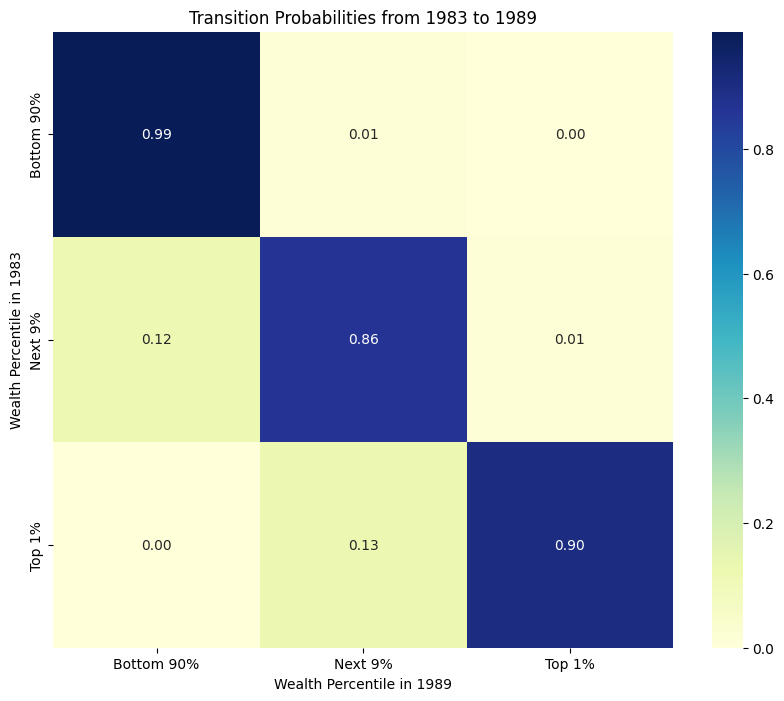

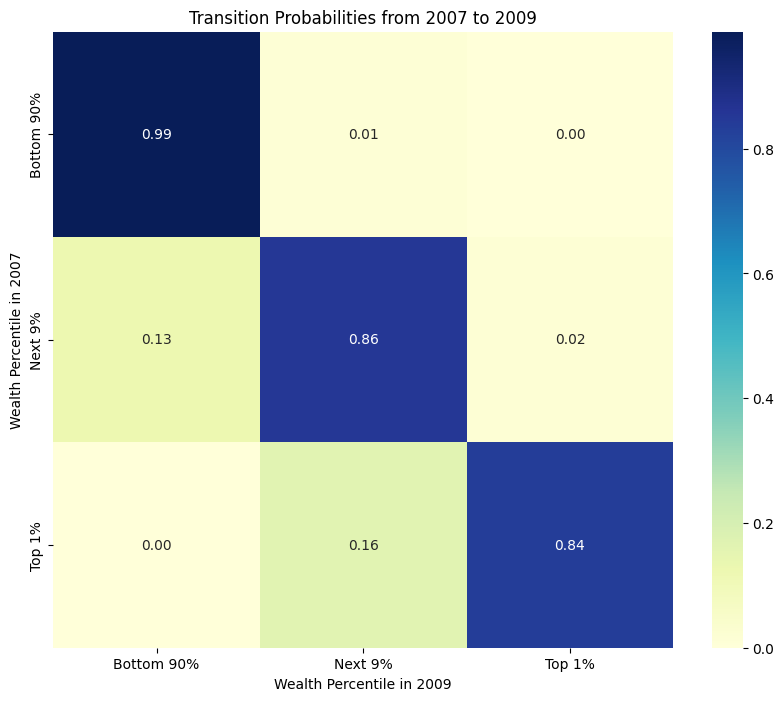

In [438]:
for year1, year2 in zip([1983,2007],[1989,2009]):

    df = load_data(f'scf_{year1}t{year2}_panel.csv')
    
    quantiles = [0.9,0.99,1]
    quantile_labels = ['Bottom 90%', 'Next 9%', 'Top 1%']
    transition_matrix = get_transition_matrix(df, quantiles, quantile_labels, col1=f'networth{year1}', col2=f'networth{year2}')

    # Annualize 
    Lambda = annualize_transitions(transition_matrix, years=year2-year1)
    Lambda = pd.DataFrame(Lambda, index=quantile_labels, columns=quantile_labels)

    # Plot heat map
    plt.figure(figsize=(10, 8))
    sns.heatmap(Lambda, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0)
    plt.title(f"Transition Probabilities from {year1} to {year2}")
    plt.xlabel(f"Wealth Percentile in {year2}")
    plt.ylabel(f"Wealth Percentile in {year1}")
    plt.show()

In [190]:
# Get annual transition probabilities
groups=np.array([25,25,25,15,5,4,1])/100
values=np.array([[67.2,24.5, 6.4, 1.8, 0.1, 0.0, 0.0],
                 [24.6,49.9,19.2, 3.7, 1.9, 0.7, 0.0],
                 [ 6.7,18.6,46.8,22.5, 3.9, 1.6, 0.0],
                 [ 1.4, 8.0,33.6,41.1,11.4, 4.3, 0.2],
                 [ 2.6, 9.4,21.6,27.3,22.8,16.0, 0.3],
                 [ 0.0, 3.8,18.5, 9.5,16.4,42.5, 9.3],
                 [ 0.0, 3.0, 2.4, 6.1, 4.5,25.1,58.9]])/100

new_groups=[0]*4 + [1]*2 + [2]
new_shares=np.array([90,9,1])/100
transition_matrix=np.zeros((3,3))


for i, share1983 in enumerate(groups):
    for j,share1989 in enumerate(groups):
        transition_matrix[new_groups[i],new_groups[j]] += share1983 * values[i,j]
        
transition_matrix=transition_matrix/np.sum(transition_matrix, axis=1)[:, None]

Lambda = annualize_transitions(transition_matrix, years=6)
Lambda = pd.DataFrame(Lambda, index=[90,9,1], columns=[90,9,1]).reset_index(names='Percentile 1983')
Lambda = Lambda.melt(id_vars='Percentile 1983', var_name='Percentile 1989', value_name='Transition Prob')

array([[ 0.99,  0.01, -0.  ],
       [ 0.11,  0.88,  0.01],
       [ 0.  ,  0.08,  0.91]])

In [198]:
# Adjust saving
df = load_data('fof_savings_by_asset.csv')

df['L_Amount'] = df['L_Amount'] * (1 + df['Asset Inflation Rate'])
df = df.groupby(['Year','Percentile','NationalInc'])[['Amount','L_Amount']].sum().reset_index()

df = df.merge(Lambda, left_on='Percentile', right_on='Percentile 1989')

df['AmountExit'] = df['Amount'] * df['Transition Prob'] * df['Percentile 1983']/df['Percentile 1989']
df['L_AmountExit'] = df['L_Amount']
df.loc[df['Percentile 1983']!=df['Percentile 1989'], 'L_AmountExit'] = 0

df = df.groupby(['Year', 'Percentile 1983', 'NationalInc'])[['AmountExit', 'L_AmountExit']].sum().reset_index()
df['SavExit'] = df['AmountExit'] - df['L_AmountExit']
df['SavExit2NI'] = df['SavExit']/df['NationalInc']
df = df.rename(columns={'Percentile 1983':'Percentile'})

exit = df[['Percentile','Year','SavExit2NI']].copy()

In [199]:
# Adjust saving
df = load_data('fof_savings_by_asset.csv')

df['L_Amount'] = df['L_Amount'] * (1 + df['Asset Inflation Rate'])
df = df.groupby(['Year','Percentile','NationalInc'])[['Amount','L_Amount']].sum().reset_index()

df = df.merge(Lambda, left_on='Percentile', right_on='Percentile 1983')

df['AmountEnter'] = df['Amount']
df.loc[df['Percentile 1983']!=df['Percentile 1989'], 'AmountEnter'] = 0
df['L_AmountEnter'] = df['L_Amount'] * df['Transition Prob']

df = df.groupby(['Year', 'Percentile 1989', 'NationalInc'])[['AmountEnter', 'L_AmountEnter']].sum().reset_index()
df['SavEnter'] = df['AmountEnter'] - df['L_AmountEnter']
df['SavEnter2NI'] = df['SavEnter']/df['NationalInc']
df = df.rename(columns={'Percentile 1989':'Percentile'})

enter = df[['Percentile','Year','SavEnter2NI']].copy()

In [200]:
unadj = load_data('fof_savings.csv')
df = exit.merge(enter, on=['Year', 'Percentile'])
df = df.merge(unadj, on=['Year', 'Percentile'])
save_data(df, 'adjusted_savings.csv')

# Repeat Using Smoothed Probability Function

In [287]:
from scipy.optimize import minimize, least_squares
import scipy.stats as stats

In [312]:
# Create smooth probability function
df = load_data('scf_83t89_panel.csv')
quantiles = np.linspace(1,100,100)/100
quantile_labels = np.arange(100)
transition_matrix = get_transition_matrix(df, quantiles, quantile_labels)

In [313]:
# Create a new 3x3 matrix
transition_matrix = transition_matrix.to_numpy()
new_matrix = np.zeros((3, 3))

# Sum the appropriate sections
new_matrix[0, 0] = np.sum(transition_matrix[:90, :90])
new_matrix[0, 1] = np.sum(transition_matrix[:90, 90:99])
new_matrix[0, 2] = np.sum(transition_matrix[:90, 99])
new_matrix[1, 0] = np.sum(transition_matrix[90:99, :90])
new_matrix[1, 1] = np.sum(transition_matrix[90:99, 90:99])
new_matrix[1, 2] = np.sum(transition_matrix[90:99, 99])
new_matrix[2, 0] = np.sum(transition_matrix[99, :90])
new_matrix[2, 1] = np.sum(transition_matrix[99, 90:99])
new_matrix[2, 2] = np.sum(transition_matrix[99, 99])

# new_matrix=new_matrix/np.sum(new_matrix, axis=1)[:, None]

# Print the new 3x3 matrix
np.round(new_matrix, 3)

array([[8.4655e+01, 4.3040e+00, 4.1000e-02],
       [4.3560e+00, 4.2780e+00, 3.6600e-01],
       [2.5000e-02, 3.8800e-01, 5.8700e-01]])

In [ ]:
84.

In [281]:
# Calculate variance
var = np.sum((df['percentile1983']-df['percentile1989'])**2)/(len(df)-1)

In [266]:
df.loc[df.percentile1983==0, 'percentile1983'] = 1
df.loc[df.percentile1989==0, 'percentile1989'] = 1

In [267]:
Lambda = transition_matrix.to_numpy()
Lambda = pd.DataFrame(Lambda, index=quantile_labels, columns=quantile_labels).reset_index(names='Percentile 1983')
Lambda = Lambda.melt(id_vars='Percentile 1983', var_name='Percentile 1989', value_name='Transition Prob')

In [ ]:
def objective(params, tot):
    scale, sigma = params
    
    for p1 in range(100):
        for p2 in range(100):
            prob = stats.norm.pdf(p2, loc=x1, scale=sigma)

# Estimate Change in Saving Based on 83/89 - 07/09 Panels

In [ ]:
# Need to go asset by asset and incorporate inflation

In [467]:
M = np.random.rand(3,3)
print(M.sum())

4.880948104958643


In [471]:
X = M.copy()

In [472]:
for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        for ip in range(-1,2):
            for jp in range(-1,2):
                if i+ip>=0 and i+ip<M.shape[0] and j+jp>=0 and j+jp<M.shape[1]:
                     X[i,j] = (X[i,j]+M[i+ip, j+jp])/2

In [473]:
M

array([[0.29320362, 0.11239666, 0.84519133],
       [0.92901658, 0.8225106 , 0.21287608],
       [0.72978389, 0.17068326, 0.76528609]])

In [474]:
X

array([[0.69420948, 0.49086712, 0.47756386],
       [0.45127455, 0.57928218, 0.5348249 ],
       [0.47427646, 0.57272787, 0.55116066]])